# Imports

In [21]:
import math
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error
import skimage


In [3]:
BABOON_PATH = '/content/drive/MyDrive/Semester 8/Computer Vision/HW/4/Baboon.bmp'
LENA_PATH = '/content/drive/MyDrive/Semester 8/Computer Vision/HW/4/Lena.bmp'
HARRIS_PATH = '/content/drive/MyDrive/Semester 8/Computer Vision/HW/4/harris.JPG'
SL_PATH = '/content/drive/MyDrive/Semester 8/Computer Vision/HW/4/sl.jpg'
SM_PATH = '/content/drive/MyDrive/Semester 8/Computer Vision/HW/4/sm.jpg'
SR_PATH = '/content/drive/MyDrive/Semester 8/Computer Vision/HW/4/sr.jpg'

# 1. Color

## 1.1. Color space

### 1.1.1. 
Convert Lena to HSV format, and display the H, S, V components as separate grayscale images.

<img src="https://www.codespeedy.com/wp-content/uploads/2020/06/RGB-to-HSV.png"  width="400" height="500">

In [4]:
img = cv2.imread(LENA_PATH)
N = len(img)

In [5]:
r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
r, g, b = r / 255.0, g / 255.0, b / 255.0
img_hsv = np.zeros(shape=img.shape)
h,s,v = img_hsv[:, :, 0], img_hsv[:, :, 1], img_hsv[:, :, 2]

In [6]:
def get_h(r,g,b,cmax,delta):
  if delta == 0:
    h = 0
  elif cmax == r:
        h = (60 * math.fmod((g - b) / delta, 6));
  elif (cmax == g):
      h = (60 * ((b - r) / delta + 2) );
  elif (cmax == b):
      h = (60 * ((r - g) / delta + 4));
  return h

In [7]:
for i in range(N):
  for j in range(N):
    cmax = max(r[i][j], max(g[i][j],b[i][j]))
    cmin = min(r[i][j], min(g[i][j],b[i][j]))
    delta  = cmax - cmin

    h[i][j] =  get_h(r[i][j],g[i][j],b[i][j],cmax,delta)
    
    if cmax == 0:
      s[i][j] = 0
    else:
      s[i][j] = delta/cmax
    
      v[i][j] = cmax

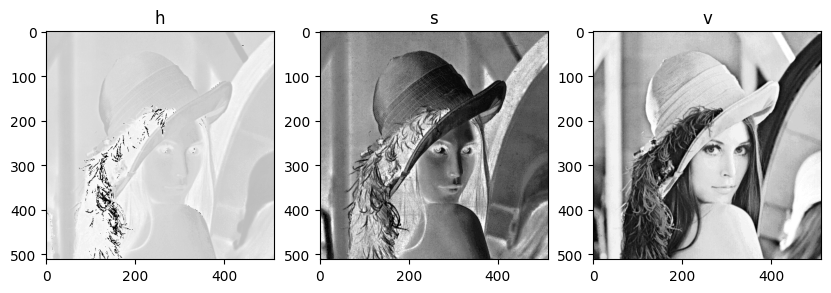

In [8]:
plt.figure(figsize=(10,15))

plt.subplot(1,3,1)
plt.imshow(h,  cmap = 'gray')
plt.title("h")

plt.subplot(1,3,2)
plt.imshow(s,  cmap = 'gray')
plt.title("s")

plt.subplot(1,3,3)
plt.imshow(v,  cmap = 'gray')
plt.title("v")

plt.show()


### 1.1.2.
Present Lena in a new color space which was not introduced in class. Then convert R, G and B to the new color space components manually.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fcdfdebe09590e617de9e523514a79f506086a74)

In [9]:
# https://en.wikipedia.org/wiki/YIQ

In [10]:
def RGB2YIQ(img):

    matrix = np.array([
    [0.299, 0.587, 0.114],
    [0.5959, -0.2746, -0.3213],
    [0.2115, -0.5227, 0.3112]
])
    
    image_shape=img.shape
    return np.dot(img.reshape(-1,3), matrix.transpose()).reshape(image_shape)

In [11]:
yiq = RGB2YIQ(img)

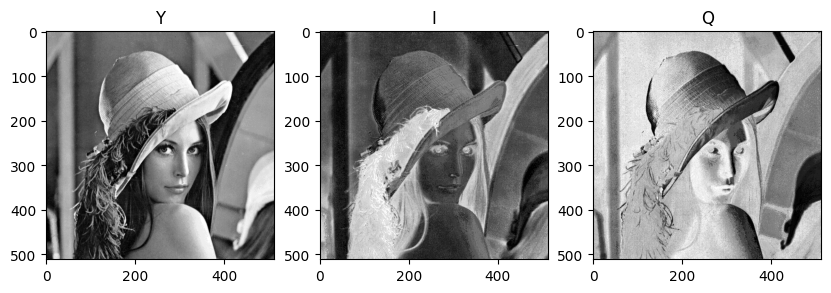

In [12]:
plt.figure(figsize=(10,15))

plt.subplot(1,3,1)
plt.imshow(yiq[:,:,0],  cmap = 'gray')
plt.title("Y")

plt.subplot(1,3,2)
plt.imshow(yiq[:,:,1],  cmap = 'gray')
plt.title("I")

plt.subplot(1,3,3)
plt.imshow(yiq[:,:,2],  cmap = 'gray')
plt.title("Q")

plt.show()


## 1.2. Quantization

### 1.2.1. 
We want to weave the Baboon image on a rug. To do so, we need to reduce the number of colors in the image with minimal visual quality loss. If we can have 32, 16 and 8 different colors in the weaving process, reduce the color of the image to these three special modes. Compare using MSE and PSNR and display the results.

In [13]:
def reduce_color(img, num_of_colors):
  reshaped_img = img.reshape((-1,3))
  reshaped_img = np.float32(reshaped_img)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10,
  1.0)
  _,labels,center = cv2.kmeans(data=reshaped_img, K=num_of_colors,bestLabels= None, criteria= criteria, attempts= 10,
                                 flags = cv2.KMEANS_RANDOM_CENTERS)
  
  center = np.uint8(center)
  result = center[labels.flatten()].reshape((img.shape))
  mse = np.mean((result - img)**2)  
  # mse = mean_squared_error(result,img)
  psnr =  skimage.metrics.peak_signal_noise_ratio(img, result)
  print(f'Image with {num_of_colors} colors: mse = {mse}, psnr = {psnr}')
  return result

In [14]:
img = cv2.imread(BABOON_PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [15]:
img_32 = reduce_color(img, 32)
img_16 = reduce_color(img, 16)
img_8 = reduce_color(img, 8)

Image with 32 colors: mse = 69.18776194254558, psnr = 26.648642362950806
Image with 16 colors: mse = 77.91373062133789, psnr = 24.767411809064207
Image with 8 colors: mse = 86.1900749206543, psnr = 22.393108381362694


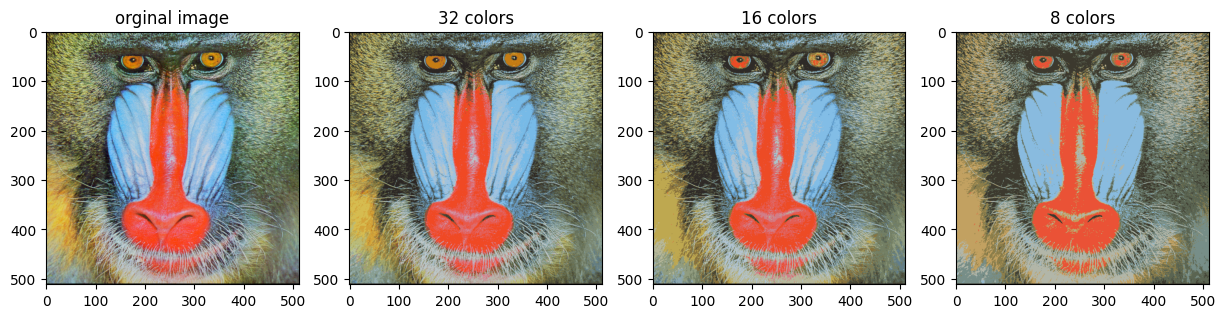

In [16]:
plt.figure(figsize=(15,20))

plt.subplot(1,4,1)
plt.imshow(img)
plt.title("orginal image")

plt.subplot(1,4,2)
plt.imshow(img_32)
plt.title("32 colors")

plt.subplot(1,4,3)
plt.imshow(img_16)
plt.title("16 colors")

plt.subplot(1,4,4)
plt.imshow(img_8)
plt.title("8 colors")

plt.show()


# 2. Features

## 2.1. Harris Corner Detector

### 2.1.1.
Extract interest points using the Harris Corner detector that you implemented. In this way, apply the Harris Corner detector for at least 4 different scales. Which interest points do you observe to be detected across all these different scales? Notice that your implementation should allow for any suitable scale as input, however you can show results on a minimum of 4 different scales (Test on harris.JPG Image).

In [34]:
def harris_corner_detector(img, scale):
  threshold = 0.1
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = np.float32(gray)
  # resize both the width and height by a scaling factor scale
  gray = cv2.resize(gray, None, fx=scale, fy=scale)
  dst = cv2.cornerHarris(gray, 2, 3, 0.04)
  # dilating result for marking the corners
  dst = cv2.dilate(dst, None)
  # get a 2D array of interest points.
  interest_points = np.column_stack(np.where(dst > threshold * dst.max()))
  # convert back to the coordinates in the original image
  interest_points = interest_points / scale
  return interest_points

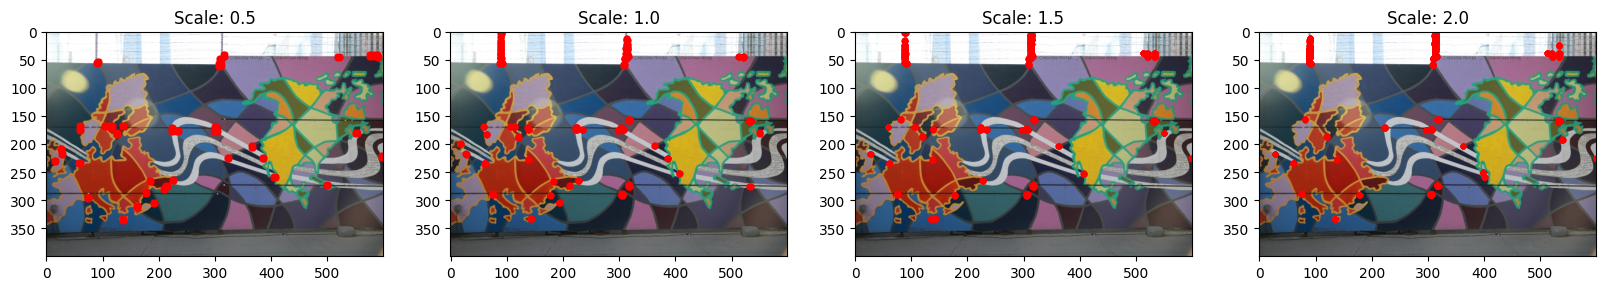

In [35]:
img = cv2.imread(HARRIS_PATH)

scales = [0.5, 1.0, 1.5, 2.0]
interest_points = []
for scale in scales:
    interest_points.append(harris_corner_detector(img, scale=scale))

fig, axs = plt.subplots(1, len(scales), figsize=(20, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.scatter(interest_points[i][:, 1], interest_points[i][:, 0], color='red', s=10)
    ax.set_title('Scale: {}'.format(scales[i]))
plt.show()

## 2.2. Scene stitching with SIFT/SURF features


### 2.2.1.
Use the OpenCV implementation of the SIFT or SURF operator to find interest points and establish correspondences between the images. In this case you can directly compare the feature vectors of interest points. You will match and align between different views of a scene with SIFT/SURF features. Discuss results and demonstrates the output of each method separately (Test on sl, sm and sr.jpg images).

In [36]:
def sift_matching(img1, img2, img3):
  # SIFT
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
  keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
  keypoints3, descriptors3 = sift.detectAndCompute(img3, None)

  # Finding matches
  bf = cv2.BFMatcher()
  matches12 = bf.knnMatch(descriptors1, descriptors2, k=2)
  matches13 = bf.knnMatch(descriptors1, descriptors3, k=2)
  matches23 = bf.knnMatch(descriptors2, descriptors3, k=2)

  # Finding good matches in Picture 1 and Picture 2
  good_matches12 = []
  for m, n in matches12:
    if m.distance < 0.75 * n.distance:
        good_matches12.append(m)
          
  # Finding good matches in Picture 1 and Picture 3
  good_matches13 = []
  for m, n in matches13:
    if m.distance < 0.75 * n.distance:
      good_matches13.append(m)

  # Finding good matches in Picture 2 and Picture 3
  good_matches23 = []
  for m, n in matches23:
    if m.distance < 0.75 * n.distance:
      good_matches23.append(m)

  # Draw matches
  img_matches12 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches12, None)
  img_matches13 = cv2.drawMatches(img1, keypoints1, img3, keypoints3, good_matches13, None)
  img_matches23 = cv2.drawMatches(img2, keypoints2, img3, keypoints3, good_matches23, None)

  return img_matches12, img_matches13, img_matches23

In [41]:
sl = cv2.imread(SL_PATH)
sm = cv2.imread(SM_PATH)
sr = cv2.imread(SR_PATH)

matches = sift_matching(sl,sm,sr)

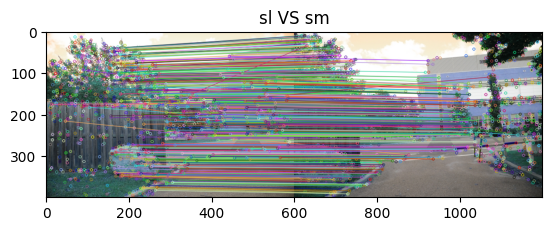

In [38]:
plt.imshow(matches[0])
plt.title("sl VS sm")
plt.show()


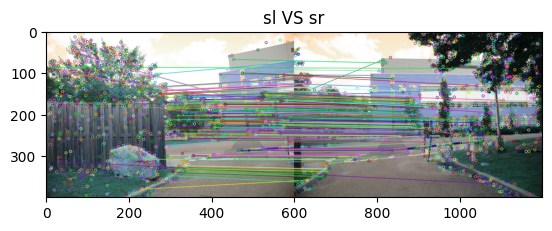

In [39]:
plt.imshow(matches[1])
plt.title("sl VS sr")
plt.show()

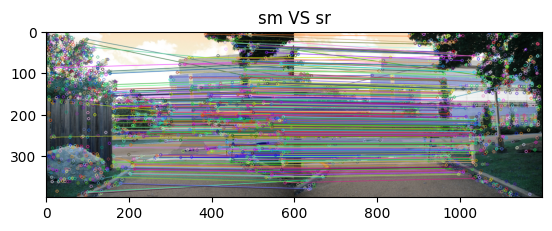

In [40]:
plt.imshow(matches[2])
plt.title("sm VS sr")

plt.show()